# HW6, DATSCI W261
Team: Kuan Lin, Alejandro J. Rojas, Ricardo Barrera<br/>
Emails: kuanlin@ischool.berkeley.edu, ale@ischool.berkeley.edu, ricardofrank@ischool.berkeley.edu<br/>
Time of Initial Submission: 8:00 AM PST, Thursday, March 10, 2016<br/>
W261-1, Spring 2016 Week 6 Homework<br/>

# General Description
In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

# HW 7.0: Shortest path graph distances (toy networks)

In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, 
as described in the lectures. In addition to finding the distances, 
your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use 
both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
<p>Solution: 1,5,4</p>

- shortest path in the directed network from node 1 to node 5
<p>Solution: 1,2,4,5</p>

and report your output---make sure it is correct!

### Parallel Breadth First Search for Single Source Shortest Path

In [74]:
%%writefile parallel_breadth_first.py
from mrjob.job import MRJob

# parallel breadth first search for single source shortest path
class pbf(MRJob):
    
    # load current shortest path from explored nodes
    def loadKnownPath(self):
        self.explored_nodes = {}
        self.frontier_nodes = set()
        for line in open('explored_nodes.txt', 'r'):
            line = line.strip()
            if line == '': continue
            lineArr = line.split('\t')
            nodeId = int(lineArr[0])
            distance_from_source = float(lineArr[1])
            shortest_path = []
            if len(lineArr) > 2: # only frontier nodes will carry path info
                for nid in lineArr[2].strip().split(','):
                    shortest_path.append(int(nid))
                self.frontier_nodes.add(nodeId)
            self.explored_nodes[nodeId] = (distance_from_source, shortest_path)
        if len(self.frontier_nodes) == 0 and len(self.explored_nodes) == 1: # initialization phase
            self.frontier_nodes.add(self.explored_nodes.keys()[0])
            
    def mapper_init(self):
        self.loadKnownPath()
        
    def mapper(self, _, line):
        line = line.strip()
        # parse adjacency list
        lineArr = line.split('\t')
        nodeId = int(lineArr[0])
        if nodeId in self.frontier_nodes: # only process nodes at the frontier
            distance_from_source, shortest_path = self.explored_nodes[nodeId]
            shortest_path.append(nodeId) # add to the current node to make shortest path to the next node
            # adjacency list should be a dictionary object
            for neighbor_nodeID,edge_weight in eval(lineArr[1]).items():
                neighbor_nodeID = int(neighbor_nodeID) # convert to int for ID for consistency
                current_distance = distance_from_source+edge_weight
                # emit if this is a new node or the path found is shorter then known path
                if neighbor_nodeID not in self.explored_nodes or current_distance < self.explored_nodes[neighbor_nodeID][0]:
                    yield neighbor_nodeID, (current_distance, shortest_path)
    
    # use combiner to preselect shortest path
    def combiner(self, nodeId, payload):
        shortest_distance = None
        shortest_path = None
        for dist,path in payload:
            if shortest_distance == None or dist < shortest_distance:
                shortest_distance = dist
                shortest_path = path
        if shortest_distance != None:
            yield nodeId, (shortest_distance, shortest_path)
    
    # pretty much the same as the combiner
    def reducer(self, nodeId, payload):
        shortest_distance = None
        shortest_path = None
        for dist,path in payload:
            if shortest_distance == None or dist < shortest_distance:
                shortest_distance = dist
                shortest_path = path
        # since I am only emitting newly explored nodes or nodes with updated distances
        # the driver can terminate if there is nothing emitted from reducer (that is,
        # more node to explore and no distance changes)
        yield nodeId, (shortest_distance, shortest_path)
        
if __name__ == '__main__':
    pbf.run()

Overwriting parallel_breadth_first.py


### Driver code for Parallel Breadth First Search

In [75]:
%%writefile pbf_driver.py
from parallel_breadth_first import pbf
import os
import sys

input_file = sys.argv[1]
source_nodeId = int(sys.argv[2])
target_nodeId = int(sys.argv[3])
if len(sys.argv) > 4:
    unweighted = int(sys.argv[4])
else:
    unweighted = 0
    
shortest_path_to_target = None
shortest_distance_to_target = 0.0

# initialize distance and shortest path for the known node - which is just the source
writer = open('explored_nodes.txt', 'w')
# format: 'nodeID'\t'shortest_distance'\t'shortes_path' (comma seperated, only for frontier nodes)
writer.write('\t'.join([str(source_nodeId), '0']) + '\n')
writer.close()

def recordUpdateNodes(updateInfo):
    writer = open('explored_nodes.txt.temp', 'w')
    written_nodes = set()
    for line in open('explored_nodes.txt', 'r'):
        line = line.strip()
        if line == '': continue
        nodeId = int(line.split('\t')[0])
        if nodeId in updateInfo:
            shortest_distance, shortest_path = updateInfo[nodeId]
            # record updated node info, and re-designate as a new frontier
            writer.write('\t'.join([str(nodeId), str(shortest_distance), ','.join(map(str,shortest_path))]) + '\n')
            written_nodes.add(nodeId)
        else:
            writer.write('\t'.join(line.split('\t')[0:2]) + '\n') # no need to keep path-info for non-frontier nodes
    # record newly discovered nodes
    for nodeId in updateInfo:
        if nodeId not in written_nodes:
            shortest_distance, shortest_path = updateInfo[nodeId]
            # newly discvoerd nodes are frontier nodes
            writer.write('\t'.join([str(nodeId), str(shortest_distance), ','.join(map(str,shortest_path))]) + '\n')
    writer.close()
    os.remove('explored_nodes.txt')
    os.rename('explored_nodes.txt.temp', 'explored_nodes.txt')


mr_job = pbf(args=[input_file, '--file', 'explored_nodes.txt'])
while(1):
    with mr_job.make_runner() as runner:
        runner.run()
        # stream_output: get access of the output
        updated_nodes = {}
        for line in runner.stream_output():
            nodeId,payload = mr_job.parse_output_line(line)
            updated_nodes[nodeId] = payload
        if len(updated_nodes) > 0:
            #print str(updated_nodes)
            recordUpdateNodes(updated_nodes)
            if target_nodeId in updated_nodes:
                shortest_distance_to_target, shortest_path_to_target = updated_nodes[target_nodeId]
                if unweighted > 0: # in unweighted graph, we cann terminate once we found the target in the first time
                    break
        else:
            break # no new updated information about the nodes
            
print "Shortest distance from node%s to node%s: %s"%(source_nodeId, target_nodeId, shortest_distance_to_target)
print "via path: %s"%(','.join(map(str,shortest_path_to_target)) + ',' + str(target_nodeId))

Overwriting pbf_driver.py


In [84]:
# test shortest path in the undirected network from node 1 to node 4
# Solution: 1,5,4 
!python pbf_driver.py undirected_toy.txt 1 4 1

Shortest distance from node1 to node4: 2.0
via path: 1,2,4


No handlers could be found for logger "mrjob.runner"


In [85]:
for line in open('explored_nodes.txt', 'r'): print line.strip()

1	0
2	1.0
5	1.0
3	2.0	1,2
4	2.0	1,2


In [89]:
# test shortest path in the directed network from node 1 to node 5
# Solution: 1,2,4,5
!python pbf_driver.py directed_toy.txt 4 6 1

Shortest distance from node4 to node6: 3.0
via path: 4,2,1,6


No handlers could be found for logger "mrjob.runner"


In [90]:
for line in open('explored_nodes.txt', 'r'): print line.strip()

4	0
2	1.0
5	1.0
1	2.0
3	2.0
6	3.0	4,2,1


# Main dataset 1: NLTK synonyms

In the next part of this assignment you will explore a network derived from
the NLTK synonym database used for evaluation in HW 5. At a high level, this
network is undirected, defined so that there exists link between two nodes/words 
if the pair or words are a synonym. These data may be found at the location:

s3://ucb-mids-mls-networks/synNet/synNet.txt<br/>
s3://ucb-mids-mls-networks/synNet/indices.txt<br/>
On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).

# HW 7.1: Exploratory data analysis (NLTK synonyms)

Using MRJob, explore the synonyms network data.<br/>
Consider plotting the degree distribution (does it follow a power law?),<br/>
and determine some of the key features, like:<br/>

number of nodes, <br/>
number links,<br/>
or the average degree (i.e., the average number of links per node),<br/>
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). <br/>
Once you have gotten you code to run locally, deploy it on AWS as a systems test<br/>
in preparation for our next dataset (which will require AWS).

In [19]:
%%writefile synNetEDA.py
from mrjob.job import MRJob

class synNetEDA(MRJob):
    
    def mapper_init(self):
        # hold node degrees
        self.degrees = []
    
    def mapper(self, _, line):
        line = line.strip()
        # outlinks are dictionary objs
        links = eval(line.split('\t')[1])
        # record degree information
        self.degrees.append(len(links))
        
    def mapper_final(self):
        # emit node degrees
        yield None, self.degrees
        
    def reducer(self, _, degree_info):
        for info in degree_info:
            yield None, info
                
if __name__ == '__main__':
    synNetEDA.run()

Overwriting synNetEDA.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of Nodes: 1000
Number of Links: 6854
Average Node Degrees: 13.709


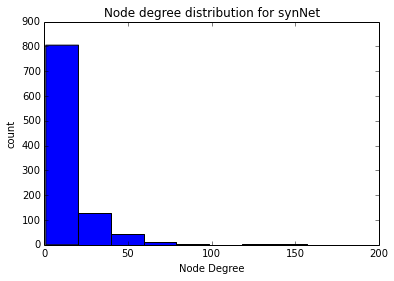

In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# driver code for synNet EDA
from synNetEDA import synNetEDA

mr_job = synNetEDA(args=['synNet_reduced.txt'])
with mr_job.make_runner() as runner: 
    runner.run()
    num_nodes = 0 # number of nodes
    num_links = 0 # number of links
    total_degrees = 0 # total number of degrees
    degrees_dist = []
    for line in runner.stream_output():
        degree_nums = mr_job.parse_output_line(line)[1]
        num_nodes += len(degree_nums)
        num_links += sum(degree_nums)
        total_degrees += sum(degree_nums)
        degrees_dist += degree_nums
        
num_links = num_links/2 # since this is undirected graph, we are double counting links
avg_degree = total_degrees*1.0/num_nodes # average number of degrees per node

print "Number of Nodes: %s"%num_nodes
print "Number of Links: %s"%num_links
print "Average Node Degrees: %s"%avg_degree
    
# plot the distribution of average node degree

plt.hist(degrees_dist)
plt.title("Node degree distribution for synNet")
plt.xlabel("Node Degree")
plt.ylabel("count")
plt.show()

# HW 7.2: Shortest path graph distances (NLTK synonyms)

Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, <br/>
and apply it to the NLTK synonyms network dataset.

Proof your code's function by running the job:<br/>

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). <br/>
Once you have gotten you code to run locally, deploy it on AWS as a systems test<br/>
in preparation for our next dataset (which will require AWS).

#### The code from 7.0 should be able to handle this problem without further modification

In [88]:
!python pbf_driver.py synNet.txt 7827 536 1

Shortest distance from node7827 to node536: 3.0
via path: 7827,1426,1668,536


No handlers could be found for logger "mrjob.runner"


# Main dataset 2: English Wikipedia

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.<br/>
The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.<br/>
For this directed network, a link between articles: <br/>

A -> B

is defined by the existence of a hyperlink in A pointing to B.<br/>
This network also exists in the indexed format:<br/>

Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt<br/>
Data: s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt<br/>
Data: s3://ucb-mids-mls-networks/wikipedia/indices.txt<br/>
On under the Data Subfolder for HW7 on Dropbox with the same file names<br/>

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .<br/>
Here, a weight indicates the number of time a page links to another.<br/>
However, for the sake of this assignment, treat this an unweighted network,<br/>
and set all weights to 1 upon data input.

# HW 7.3: Exploratory data analysis (Wikipedia)

Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 
Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 
This means that you may have to ADJUST your code (depending on its design). 
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

#### The code from 7.1 will need the following modification:
- Need to account for nodes with no outlink
- Need to perform resovior sampling to get the final degree distribution in order to scale out.

The code below will do that.

In [30]:
%%writefile wikiEDA.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from random import randint

class wikiEDA(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper_init=self.first_pass_mapper_init, mapper=self.node_info_mapper, 
                   mapper_final=self.node_info_mapper_final, reducer=self.node_info_reducer),
            MRStep(reducer=self.final_aggregation)
        ]
    
    # setup first pass mapper to hold link counts for each node
    def first_pass_mapper_init(self):
        self.node_info = {}
    
    # first pass mapper, collect link/degree information for each node
    def node_info_mapper(self, _, line):
        lineArr = line.strip().split('\t')
        nodeId = int(lineArr[0]) # nodeId to be documented for outlinks
        nodeLinks = eval(lineArr[1]) # outlink information
        self.node_info.setdefault(nodeId, [0, 0]) # [inlink, outlink]
        self.node_info[nodeId][1] += sum(nodeLinks.values()) # add to outlink counts
        for neighbor in nodeLinks:
            neighborId = int(neighbor)
            self.node_info.setdefault(neighborId, [0, 0])
            self.node_info[neighborId][0] += nodeLinks[neighbor] # add to inlink counts
    
    def node_info_mapper_final(self):
        # emit by nodeId so that reducer can perform final aggregation
        for nodeId, linkInfo in self.node_info.items():
            yield nodeId, linkInfo
            
    def node_info_reducer(self, nodeId, linkInfos):
        # aggregate all link information for each node
        inLinkCounts = 0
        outLinkCounts = 0
        for inCount,outCount in linkInfos:
            inLinkCounts += inCount
            outLinkCounts += outCount
        # send to second step for a final aggregation
        yield None, (inLinkCounts, outLinkCounts)
        
    # sample k from stream
    def resoviar_sampling(self, pool_size, current_pool, stream_idx, stream_item):
        if len(current_pool) < pool_size:
            current_pool.append(stream_item)
        else:
            j = randint(0, stream_idx)
            if j < pool_size:
                current_pool[j] = stream_item
        
    def final_aggregation(self, _, linkInfos):
        total_node_counts = 0
        total_inLinkCounts = 0
        total_outLinkCounts = 0
        link_sample = [] # sample of node links
        
        idx = 0
        for inLinkCounts,outLinkCounts in linkInfos:
            total_node_counts += 1
            total_inLinkCounts += inLinkCounts
            total_outLinkCounts += outLinkCounts
            self.resoviar_sampling(500, link_sample, idx, (inLinkCounts,outLinkCounts)) # sample 500 from stream
            idx += 1
        
        yield None, (total_node_counts, total_inLinkCounts, total_outLinkCounts, link_sample) 
                
if __name__ == '__main__':
    wikiEDA.run()

Overwriting wikiEDA.py


#### Driver for Wiki EDA

In [32]:
# configuration for running MRJob on EMR
import os

aws_id = os.environ['AWSAccessKeyId']
aws_key = os.environ['AWSSecretKey']

writer = open('mrjob_emr.conf', 'w')
writer.write(
"""runners:
  emr:
    aws_access_key_id: %s
    aws_region: us-east-1
    ec2_instance_type: m1.medium
    ec2_master_instance_type: m1.medium
    num_ec2_instances: 3
    aws_secret_access_key: %s"""%(aws_id, aws_key)
)
writer.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of Nodes: 15192277
Number of in-Links: 185243029
Number of out-Links: 185243029


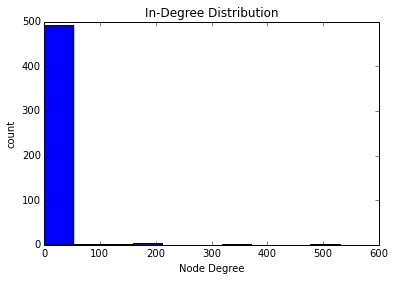

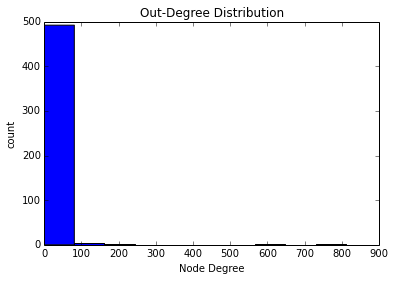

In [33]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# driver code for wiki EDA
from wikiEDA import wikiEDA

mr_job = wikiEDA(args=['-r', 'emr', '-c', 'mrjob_emr.conf', 's3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt'])
with mr_job.make_runner() as runner: 
    runner.run()
    for line in runner.stream_output():
        total_node_counts, total_inLinkCounts, total_outLinkCounts, degree_sample = mr_job.parse_output_line(line)[1]

print "Number of Nodes: %s"%total_node_counts
print "Number of in-Links: %s"%total_inLinkCounts
print "Number of out-Links: %s"%total_outLinkCounts
    
# plot the distribution of average node degree

plt.hist([i[0] for i in degree_sample])
plt.title("In-Degree Distribution")
plt.xlabel("Node Degree")
plt.ylabel("count")
plt.show()

plt.hist([i[1] for i in degree_sample])
plt.title("Out-Degree Distribution")
plt.xlabel("Node Degree")
plt.ylabel("count")
plt.show()

# HW 7.4: Shortest path graph distances (Wikipedia)

Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.<br/>
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.<br/>
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output.

Once your code is running, find some other shortest paths and report your results.

#### The code from 7.2 will work with directed graph.  But will need to make the following modifications:
- Use only 1 as weight as stated in the problem.
- Output additional shortest paths

In [1]:
%%writefile wiki_parallel_breadth_first.py
from mrjob.job import MRJob

# parallel breadth first search for single source shortest path
class pbf(MRJob):
    
    # load current shortest path from explored nodes
    def loadKnownPath(self):
        self.explored_nodes = {}
        self.frontier_nodes = set()
        for line in open('explored_nodes.txt', 'r'):
            line = line.strip()
            if line == '': continue
            lineArr = line.split('\t')
            nodeId = int(lineArr[0])
            distance_from_source = float(lineArr[1])
            shortest_path = []
            if len(lineArr) > 2: # only frontier nodes will carry path info
                for nid in lineArr[2].strip().split(','):
                    shortest_path.append(int(nid))
                self.frontier_nodes.add(nodeId)
            self.explored_nodes[nodeId] = (distance_from_source, shortest_path)
        if len(self.frontier_nodes) == 0 and len(self.explored_nodes) == 1: # initialization phase
            self.frontier_nodes.add(self.explored_nodes.keys()[0])
            
    def mapper_init(self):
        self.loadKnownPath()
        
    def mapper(self, _, line):
        line = line.strip()
        # parse adjacency list
        lineArr = line.split('\t')
        nodeId = int(lineArr[0])
        if nodeId in self.frontier_nodes: # only process nodes at the frontier
            distance_from_source, shortest_path = self.explored_nodes[nodeId]
            shortest_path.append(nodeId) # add to the current node to make shortest path to the next node
            # adjacency list should be a dictionary object
            for neighbor_nodeID,edge_weight in eval(lineArr[1]).items():
                neighbor_nodeID = int(neighbor_nodeID) # convert to int for ID for consistency
                #current_distance = distance_from_source+edge_weight
                current_distance = distance_from_source+1 # set all weights to 1 per stated in the problem
                # emit if this is a new node or the path found is shorter then known path
                if neighbor_nodeID not in self.explored_nodes or current_distance < self.explored_nodes[neighbor_nodeID][0]:
                    yield neighbor_nodeID, (current_distance, shortest_path)
    
    # use combiner to preselect shortest path
    def combiner(self, nodeId, payload):
        shortest_distance = None
        shortest_path = None
        for dist,path in payload:
            if shortest_distance == None or dist < shortest_distance:
                shortest_distance = dist
                shortest_path = path
        if shortest_distance != None:
            yield nodeId, (shortest_distance, shortest_path)
    
    # pretty much the same as the combiner
    def reducer(self, nodeId, payload):
        shortest_distance = None
        shortest_path = None
        for dist,path in payload:
            if shortest_distance == None or dist < shortest_distance:
                shortest_distance = dist
                shortest_path = path
        # since I am only emitting newly explored nodes or nodes with updated distances
        # the driver can terminate if there is nothing emitted from reducer (that is,
        # more node to explore and no distance changes)
        yield nodeId, (shortest_distance, shortest_path)
        
if __name__ == '__main__':
    pbf.run()

Writing wiki_parallel_breadth_first.py


### Driver Code for Wiki Shortest Paths

In [13]:
%%writefile wiki_pbf_driver.py
from wiki_parallel_breadth_first import pbf
import os
import sys

input_file = sys.argv[1]
source_nodeId = int(sys.argv[2])
target_nodeId = int(sys.argv[3])
if len(sys.argv) > 4:
    unweighted = int(sys.argv[4])
else:
    unweighted = 0
    
shortest_path_to_target = None
shortest_distance_to_target = 0.0

# initialize distance and shortest path for the known node - which is just the source
writer = open('explored_nodes.txt', 'w')
# format: 'nodeID'\t'shortest_distance'\t'shortes_path' (comma seperated, only for frontier nodes)
writer.write('\t'.join([str(source_nodeId), '0']) + '\n')
writer.close()

def recordUpdateNodes(updateInfo):
    writer = open('explored_nodes.txt.temp', 'w')
    written_nodes = set()
    for line in open('explored_nodes.txt', 'r'):
        line = line.strip()
        if line == '': continue
        nodeId = int(line.split('\t')[0])
        if nodeId in updateInfo:
            shortest_distance, shortest_path = updateInfo[nodeId]
            # record updated node info, and re-designate as a new frontier
            writer.write('\t'.join([str(nodeId), str(shortest_distance), ','.join(map(str,shortest_path))]) + '\n')
            written_nodes.add(nodeId)
        else:
            writer.write('\t'.join(line.split('\t')[0:2]) + '\n') # no need to keep path-info for non-frontier nodes
    # record newly discovered nodes
    for nodeId in updateInfo:
        if nodeId not in written_nodes:
            shortest_distance, shortest_path = updateInfo[nodeId]
            # newly discvoerd nodes are frontier nodes
            writer.write('\t'.join([str(nodeId), str(shortest_distance), ','.join(map(str,shortest_path))]) + '\n')
    writer.close()
    os.remove('explored_nodes.txt')
    os.rename('explored_nodes.txt.temp', 'explored_nodes.txt')


# config to run on EMR
mr_job = pbf(args=['-r', 'emr', '-c', 'mrjob_emr.conf', '--pool-emr-job-flows', input_file, '--file', 'explored_nodes.txt'])
while(1):
    with mr_job.make_runner() as runner:
        runner.run()
        # stream_output: get access of the output
        updated_nodes = {}
        for line in runner.stream_output():
            nodeId,payload = mr_job.parse_output_line(line)
            updated_nodes[nodeId] = payload
        if len(updated_nodes) > 0:
            #print str(updated_nodes)
            recordUpdateNodes(updated_nodes)
            if target_nodeId in updated_nodes:
                shortest_distance_to_target, shortest_path_to_target = updated_nodes[target_nodeId]
                if unweighted > 0: # in unweighted graph, we cann terminate once we found the target in the first time
                    break
        else:
            break # no new updated information about the nodes
            
print "Shortest distance from node %s to node %s: %s"%(source_nodeId, target_nodeId, shortest_distance_to_target)
print "via path: %s"%(','.join(map(str,shortest_path_to_target)) + ',' + str(target_nodeId))

# print out 5 additional shortest paths:
print "---------------------------------------------"
print "Additional Shortest Pathes..."
print "---------------------------------------------"
count = 0
for nodeId in updated_nodes:
    if count >= 5: break
    shortest_distance_to_target, shortest_path_to_target = updated_nodes[nodeId]
    print "Shortest distance from node %s to node %s: %s"%(source_nodeId, nodeId, shortest_distance_to_target)
    print "via path: %s"%(','.join(map(str,shortest_path_to_target)) + ',' + str(nodeId))
    count += 1

Overwriting wiki_pbf_driver.py


In [12]:
# configuration for running MRJob on EMR
import os

aws_id = os.environ['AWSAccessKeyId']
aws_key = os.environ['AWSSecretKey']

writer = open('mrjob_emr.conf', 'w')
writer.write(
"""runners:
  emr:
    aws_access_key_id: %s
    aws_region: us-east-1
    ec2_instance_type: m1.medium
    ec2_master_instance_type: m1.medium
    num_ec2_instances: 5
    aws_secret_access_key: %s"""%(aws_id, aws_key)
)
writer.close()

In [15]:
# EMR system test on synNet
!python wiki_pbf_driver.py synNet.txt 7827 536 1

Shortest distance from node 7827 to node 536: 3.0
via path: 7827,1426,264,536
---------------------------------------------
Additional Shortest Pathes...
---------------------------------------------
Shortest distance from node 7827 to node 4096: 3.0
via path: 7827,1426,1702,4096
Shortest distance from node 7827 to node 4097: 3.0
via path: 7827,1426,1702,4097
Shortest distance from node 7827 to node 4098: 3.0
via path: 7827,1426,1702,4098
Shortest distance from node 7827 to node 17: 3.0
via path: 7827,1426,1688,17
Shortest distance from node 7827 to node 5806: 3.0
via path: 7827,1426,5689,5806


No handlers could be found for logger "mrjob.conf"


In [16]:
# EMR full run on out-index - shortest distance from Ireland to UC Berkeley
!python wiki_pbf_driver.py s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt 6176135 13466359 1

Shortest distance from node 6176135 to node 13466359: 2.0
via path: 6176135,11607791,13466359
---------------------------------------------
Additional Shortest Pathes...
---------------------------------------------
Shortest distance from node 6176135 to node 4325376: 2.0
via path: 6176135,10598707,4325376
Shortest distance from node 6176135 to node 10966358: 2.0
via path: 6176135,13334611,10966358
Shortest distance from node 6176135 to node 9306121: 2.0
via path: 6176135,4344962,9306121
Shortest distance from node 6176135 to node 14024714: 2.0
via path: 6176135,10122138,14024714
Shortest distance from node 6176135 to node 6160395: 2.0
via path: 6176135,11051102,6160395


No handlers could be found for logger "mrjob.conf"


# HW 7.5: Conceptual exercise: Largest single-source network distances

Suppose you wanted to find the largest network distance from a single source,<br/>
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? <br/>
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...

#### Answer:
I am interpreting this as finding the "longest possible shortest path".
So at each iteration we will need to identify shortest path between nodes, and also explore further frontiers.
Assuming that the edges are unweighted, a suitable approach would be:

- Starting at the source node, for each iteration expanding frontier to the immediate neighbour nodes
  - When expanding to the neighbour nodes, check if each neighbour node has been visited before.
    In the case of unweighted graph, we don't need to re-visit the visited nodes.
	If the graph is weighted, we will need to verify if the new path is shorter than the previously found path.
- At the end of the iteration, keep track of the maximum path among visited nodes that no longer has any
  unvisited neighbours.
- Repeat the above procedure until there is no longer any frontier nodes that has unvisited neighbours.

The performance and system requirements will depend on the graph size (diameter), as we will need to continue
search along the path and could possibly having to iterate through the entire graph in the worse case scenario.

The distributed version of the program will be similar to 7.4, where we distribute the search for frontiers
to multiple machines.  The difference is the stopping criterion as aforementioned.  The runtime should exponential
increase with graph size.